# **Sistem Rekomendasi Film: Content-Based (TF-IDF) & Neural Collaborative Filtering**


## **Data Understanding**

Dataset yang digunakan untuk proyek ini yaitu dari grouplens: https://grouplens.org/datasets/movielens/ MovieLens Latest Datasets.


### **Import Library**

Kode berikut merupakan kode untuk melakukan import library yang dibutuhkan pada project ini

In [1]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Library untuk preprocessing
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


### **Data Loading**

Pada dataset terdapat 4 file .csv:
- links.csv
- movies.csv
- ratings.csv
- tags.csv

dan satu file .txt:
- README.txt

In [3]:
# Load Dataset
movies = pd.read_csv("/content/MovieLens/movies.csv")
ratings = pd.read_csv("/content/MovieLens/ratings.csv")
tags = pd.read_csv("/content/MovieLens/tags.csv")

## **Univariate Exploratory Data Analysis**

### Informasi Data

In [4]:
print("----------------------------------------------------------------------")
print("Informasi data Movies:")
print(movies.info())
print("\nLima baris awal data Movies:")
print(movies.head())
print("----------------------------------------------------------------------")

print("\nInformasi data Ratings:")
print(ratings.info())
print("\nLima baris awal data Ratings:")
print(ratings.head())
print("----------------------------------------------------------------------")

print("\nInformasi data Tags:")
print(tags.info())
print("\nLima baris awal data Tags:")
print(tags.head())
print("----------------------------------------------------------------------")


----------------------------------------------------------------------
Informasi data Movies:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None

Lima baris awal data Movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comed

- Pada fitur genres perlu dilakukan penghapusan '|' dan preprocessing pada text seperti stemming, lemmatization, tokenisasi
- pada fitur tag juga perlu dilakukan preprocessing

In [5]:
# Menampilkan berapa banyak film yang tidak memiliki rating dan tag,
all_movies = set(movies.movieId.unique())
rated_movies = set(ratings.movieId.unique())
tagged_movies = set(tags.movieId.unique())

print("Jumlah film unik (berdasarkan movieId)")
print('Jumlah semua film: ', len(all_movies))
print('Jumlah Film dengan rating: ', len(rated_movies))
print('Jumlah Film dengan tag: ', len(tagged_movies))

print("\nJumlah film tanpa rating dan tag")
print('Jumlah Film tanpa rating: ', len(all_movies - rated_movies))
print('Jumlah Film tanpa tag: ', len(all_movies - tagged_movies))


Jumlah film unik (berdasarkan movieId)
Jumlah semua film:  9742
Jumlah Film dengan rating:  9724
Jumlah Film dengan tag:  1572

Jumlah film tanpa rating dan tag
Jumlah Film tanpa rating:  18
Jumlah Film tanpa tag:  8170


- Dari hasil di atas, dapat disimpulkan bahwa tidak semua film mendapatkan rating dan tag
-  terdapat 18 film tanpa rating dan 8170 tanpa tag

### Visualisai Data

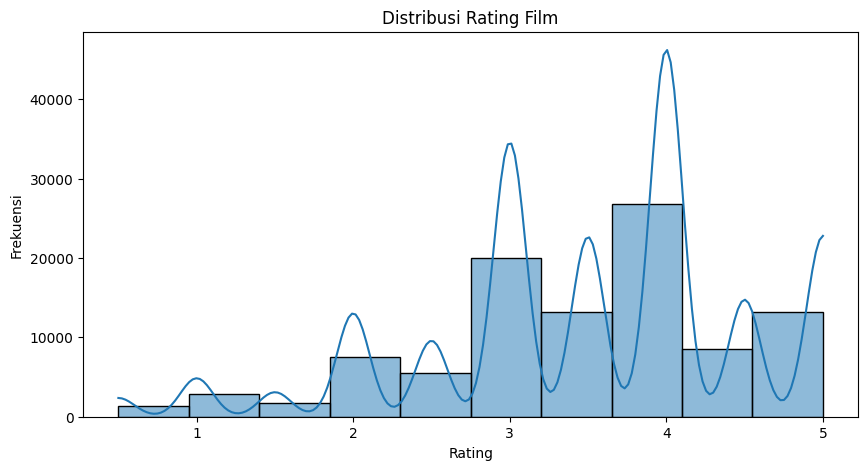

In [6]:
# Visualisai distribusi rating film
plt.figure(figsize=(10,5))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title("Distribusi Rating Film")
plt.xlabel("Rating")
plt.ylabel("Frekuensi")
plt.show()

- Dari hasil visualisai tersebut kebanyakan orang memberikan rating film dengan rating 4 dan 3


## **Data Preprocessing**


#### Duplikasi Data

In [7]:
# Mengecek duplikasi data
print("\nJumlah duplikasi pada data movies:", movies.duplicated().sum())
print("\nJumlah duplikasi pada data ratings:", ratings.duplicated().sum())
print("\nJumlah duplikasi pada data tags:", tags.duplicated().sum())


Jumlah duplikasi pada data movies: 0

Jumlah duplikasi pada data ratings: 0

Jumlah duplikasi pada data tags: 0


- Tidak terdapat data duplicate

#### Missing Value

In [8]:
# Mengecek missing value
print("\nNilai null dalam movies:")
print(movies.isnull().sum())
print("\nNilai null dalam ratings:")
print(ratings.isnull().sum())
print("\nNilai null dalam tags:")
print(tags.isnull().sum())


Nilai null dalam movies:
movieId    0
title      0
genres     0
dtype: int64

Nilai null dalam ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Nilai null dalam tags:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


- Semunya menghasilkan angka 0 berarti tidak terdapat missing value

#### Preprocessing text

- Membuat fungsi untukelakukan preprocessing seperti stemming, lemmatization, tokenisasi pada text untuk meningkatkan kualitas representasi teks

In [9]:
# Download resource
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# fungsi untuk preprocessing text
def preprocess_text(text):
    # Lowercase, hilangkan karakter selain huruf
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    # Tokenisasi
    tokens = text.split()
    # Lemmatization dan hilangkan stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Mengubah tanda '|' menjadi spasi pada genres
movies['genres'] = movies['genres'].str.replace('|', ' ', regex=False)

##### Preprocessing pada fitur genres

In [11]:
# Preprocessing
movies['genres'] = movies['genres'].apply(preprocess_text)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),adventure animation child comedy fantasy
1,2,Jumanji (1995),adventure child fantasy
2,3,Grumpier Old Men (1995),comedy romance
3,4,Waiting to Exhale (1995),comedy drama romance
4,5,Father of the Bride Part II (1995),comedy


##### Preprocessing pada fitur tag

In [12]:
tags['tag'] = tags['tag'].fillna('').apply(preprocess_text)
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,highly quotable,1445714996
2,2,60756,ferrell,1445714992
3,2,89774,boxing story,1445715207
4,2,89774,mma,1445715200


## **Data Preparation**

### Menggabungkan fitur tag ke data movies

In [13]:
# Menggabungkan tags berdasarkan movieId
combined_tags = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
movies = pd.merge(movies, combined_tags, on='movieId', how='left')
movies['tag'] = movies['tag'].fillna('')

print("\nMovies after adding tags:")
movies.head()


Movies after adding tags:


,movieId,title,genres,tag
0,1,Toy Story (1995),adventure animation child comedy fantasy,pixar pixar fun
1,2,Jumanji (1995),adventure child fantasy,fantasy magic board game robin williams game
2,3,Grumpier Old Men (1995),comedy romance,moldy old
3,4,Waiting to Exhale (1995),comedy drama romance,
4,5,Father of the Bride Part II (1995),comedy,pregnancy remake


- Mengecek kembali duplikasi data setelah dilakukan penggabungan tag ke dalam movies

In [14]:
duplicated  = movies.duplicated().sum()
print(f"Data Duplicat: {duplicated}")

Data Duplicat: 0


### Menggabungkan genre + tag menjadi satu fitur teks

In [15]:
# Fungsi untuk menghapus duplikasi kata pada hasil combined
def combine_unique_words(col1, col2):
    words = (col1 + ' ' + col2).split()
    # Menghapus duplikat dengan set, lalu mengurutkan sesuai urutan kemunculan
    unique_words = list(dict.fromkeys(words))
    return ' '.join(unique_words)

In [16]:
# Menggabungkan genre + tag menjadi satu fitur teks
movies['combined_genre_tag'] = movies.apply(lambda row: combine_unique_words(row['genres'], row['tag']), axis=1)
movies.head()

,movieId,title,genres,tag,combined_genre_tag
0,1,Toy Story (1995),adventure animation child comedy fantasy,pixar pixar fun,adventure animation child comedy fantasy pixar...
1,2,Jumanji (1995),adventure child fantasy,fantasy magic board game robin williams game,adventure child fantasy magic board game robin...
2,3,Grumpier Old Men (1995),comedy romance,moldy old,comedy romance moldy old
3,4,Waiting to Exhale (1995),comedy drama romance,,comedy drama romance
4,5,Father of the Bride Part II (1995),comedy,pregnancy remake,comedy pregnancy remake


- Pada data tersebut terdapat beberapa data tag yang kosong dikarenakan tidak semua film memiliki tag, kemudian data kosong tersebut di isi dengan nan dan kemudian diganti dengan spasi agar tidak berpengaruh ke model dan hal tersebut tidak masalah dikarenakan sudah terdapat combined fitur

### TF-IDF Vectorizer

Mengubah teks (genre film) menjadi representasi numerik yang dapat dipahami oleh algoritma machine learning

In [17]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(movies['combined_genre_tag'])

### Mapping judul ke indeks

In [18]:
# Membuat mapping judul ke indeks
indices = pd.Series(movies.index, index=movies['title'])
indices.head()

,0
title,
Toy Story (1995),0
Jumanji (1995),1
Grumpier Old Men (1995),2
Waiting to Exhale (1995),3
Father of the Bride Part II (1995),4


## **Model Development dengan Content Based Filtering**

- Model development pada Model content-based filtering menggunakan representasi data dari TF-IDF Vectorizer dan evaluasi kesamaan antar item dilakukan menggunakan Cosine Similarity."

#### Cosine similarity

In [19]:
# Cosine similarity berdasarkan TF-IDF
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.12390756, 0.01970914, ..., 0.        , 0.2203516 ,
        0.13989933],
       [0.12390756, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01970914, 0.        , 1.        , ..., 0.        , 0.        ,
        0.14088088],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.2203516 , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.13989933, 0.        , 0.14088088, ..., 0.        , 0.        ,
        1.        ]])

#### Mendapatkan Rekomendasi

- Membuat fungsi untuk Content-based Filtering yang akan melakukan rekomendasi film

In [219]:
# Fungsi rekomendasi
def recommend(title, top_n):
    idx = indices[title]

    # informasi film
    base_movie_info = movies.iloc[idx][['title', 'genres', 'combined_genre_tag']]
    print(f"--- Informasi Film: ---\n")
    print(base_movie_info.to_string())
    print("\n------------------------------")

    sim_scores = list(enumerate(cosine_sim[idx]))

    # Dapatkan hasil rekomendasi (top_n)
    recommended_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    recommended_indices = [i[0] for i in recommended_scores]
    recommended_df = movies.iloc[recommended_indices][['title', 'genres', 'tag', 'combined_genre_tag']]
    recommended_titles = recommended_df['title'].tolist()

    # Tampilkan hasil
    print(f"\n🎬 Rekomendasi untuk \"{title}\":\n")
    print(recommended_df[['title', 'genres', 'combined_genre_tag']].to_string(index=False))

- Melakukan percobaan rekomendasi berdasarkan film "God Loves Caviar (2012)" dimana akan merekomendasikan sebanyak 15 film sesuai dengan nilai top_n=15

In [221]:
# Jalankan fungsi rekomendasi dengan top_n = 15
recommend("God Loves Caviar (2012)", top_n=15)

--- Informasi Film: ---

title                 God Loves Caviar (2012)
genres                            [adventure]
combined_genre_tag                  adventure

------------------------------

🎬 Rekomendasi untuk "God Loves Caviar (2012)":

                                     title             genres combined_genre_tag
      Beyond the Poseidon Adventure (1979)        [adventure]          adventure
                 White Water Summer (1987)        [adventure]          adventure
                          Iron Will (1994)        [adventure]          adventure
              Mountains of the Moon (1990)        [adventure]          adventure
                         White Fang (1991)        [adventure]          adventure
             Wind and the Lion, The (1975)        [adventure]          adventure
Christopher Columbus: The Discovery (1992)        [adventure]          adventure
                    Treasure Island (2012)        [adventure]          adventure
                   God Love

## **Model Development dengan Collaborative Filtering**

Pada sistem rekomendasi Collaborative Filtering menggunakan Neural Collaborative Filtering (NCF)


### Data Preparation

#### Encoding

- Mengubah userId dan movieId yang bersifat kategori non-urut menjadi bentuk numeric encoding (0, 1, 2, …) agar bisa digunakan dalam model machine learning (khususnya layer Embedding).

In [222]:
# Encode userId dan movieId
user_ids = ratings['userId'].unique().tolist()
movie_ids = ratings['movieId'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
user_encoded2user = {i: x for x, i in user2user_encoded.items()}
movie_encoded2movie = {i: x for x, i in movie2movie_encoded.items()}

ratings['user'] = ratings['userId'].map(user2user_encoded)
ratings['movie'] = ratings['movieId'].map(movie2movie_encoded)
n_users = len(user2user_encoded)
n_movies = len(movie2movie_encoded)

#### Membagi Data untuk Training dan Validasi

In [223]:
# Split data
x = ratings[['user', 'movie']].values
y = ratings['rating'].values
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

- Pembagian data dilakukan, 80/20 = 80% data train dan 20% data test

### Pembuatan Model

In [224]:
# Build model dengan regularisasi
EMBEDDING_SIZE = 50
user_input = keras.Input(shape=(1,))
movie_input = keras.Input(shape=(1,))

user_embedding = layers.Embedding(n_users, EMBEDDING_SIZE)(user_input)
movie_embedding = layers.Embedding(n_movies, EMBEDDING_SIZE)(movie_input)

user_vec = layers.Flatten()(user_embedding)
movie_vec = layers.Flatten()(movie_embedding)

concat = layers.Concatenate()([user_vec, movie_vec])
dense = layers.Dense(128, activation='relu')(concat)
dense = layers.Dropout(0.3)(dense)
dense = layers.Dense(64, activation='relu')(dense)
dense = layers.Dropout(0.3)(dense)
out = layers.Dense(1)(dense)

model = keras.Model([user_input, movie_input], out)
model.compile(loss='mse', optimizer='adam')

Model ini dirancang untuk memprediksi rating pengguna terhadap film menggunakan pendekatan Neural Collaborative Filtering, yaitu:
- Mencari pola interaksi non-linear antara pengguna dan film
- Meningkatkan akurasi rekomendasi dibanding metode kolaboratif klasik

Arsitektur
- Embedding Layer untuk merepresentasikan pengguna dan film ke dalam vektor berdimensi 50.
- Concatenate Layer menggabungkan vektor pengguna dan film.
- Dense Layers bertingkat (128 → 64 unit) untuk memodelkan interaksi non-linear.
- Dropout (0.3) diterapkan setelah setiap layer Dense untuk mencegah overfitting.



### Train Model

- Penggunakan callback EarlyStopping dan ReduceLROnPlateau untuk mencegah overfitting

In [225]:
# Menggunakan Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)
]


In [226]:
# Train Model
history = model.fit(
    [x_train[:, 0], x_train[:, 1]], y_train,
    epochs=15,
    batch_size=256,
    verbose=1,
    validation_data=([x_val[:, 0], x_val[:, 1]], y_val),
    callbacks=callbacks
)


Epoch 1/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 4.2840 - val_loss: 0.8038 - learning_rate: 0.0010
Epoch 2/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9251 - val_loss: 0.7973 - learning_rate: 0.0010
Epoch 3/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8674 - val_loss: 0.7766 - learning_rate: 0.0010
Epoch 4/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8263 - val_loss: 0.7754 - learning_rate: 0.0010
Epoch 5/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8037 - val_loss: 0.7737 - learning_rate: 0.0010
Epoch 6/15
299/316 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7659
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7667 - val_loss: 0.7742 - learning_rate: 0.0010
Epoch 7/15
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7271 - val_loss: 0.7676 - learning_rate: 5.0000e-04
Epoch 8/15
315/316 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7014
Epoch 8: ReduceLROnPlateau 

- Model Neural Collaborative Filtering (NCF) berhasil dilatih selama maksimal 15 epoch

- Menggunakan batch_size = 256 untuk efisiensi pemrosesan mini-batch.

- Proses training dilengkapi dengan callback (EarlyStopping, ReduceLROnPlateau) yang membantu:

- Menghentikan training lebih awal saat val_loss tidak membaik

- Menurunkan learning rate secara adaptif untuk optimasi yang lebih stabil

Dengan menggunakan callbacks maka model berhenti pada epoch ke 10 dan mendapatkan model terbaik pada epoch ke 8 dan hasil akhir menunjukkan konvergensi model dengan nilai val_loss yang optimal, dan RMSE < 1.0, yang berarti model cukup baik dalam memprediksi rating pengguna.

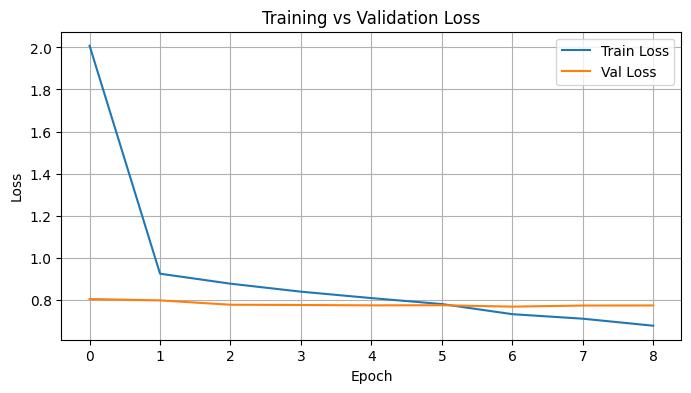

In [227]:
# Visualisasi Hasil Pelatihan
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Mendapatkan Rekomendasi Film

In [241]:
def recommend_top_n(user_id, model, ratings, movies,
                    user_map, movie_map, reverse_movie_map, top_n):
    if user_id not in user_map:
        print("User ID tidak ditemukan.")
        return pd.DataFrame()

    uid = user_map[user_id]
    all_movies = np.array(list(movie_map.values()))

    watched = ratings[ratings['userId'] == user_id]['movieId'].tolist()
    watched_encoded = [movie_map[m] for m in watched if m in movie_map]

    unwatched = np.setdiff1d(all_movies, watched_encoded)
    user_input = np.full_like(unwatched, uid)

    preds = model.predict([user_input, unwatched], verbose=0).flatten()
    top_idx = preds.argsort()[-top_n:][::-1]
    top_movie_ids = [reverse_movie_map[i] for i in unwatched[top_idx]]

    results = movies[movies['movieId'].isin(top_movie_ids)].copy()
    results['predicted_rating'] = preds[top_idx]

    return results[['movieId', 'title', 'genres', 'predicted_rating']]


In [247]:
print("Hasil Rekomendasi Movie dengan Collaborative Filtering: \n")
recommend_top_n(
    user_id=1,
    model=model,
    ratings=ratings,
    movies=movies,
    user_map=user2user_encoded,
    movie_map=movie2movie_encoded,
    reverse_movie_map=movie_encoded2movie,
    top_n=15
)


Hasil Rekomendasi Movie dengan Collaborative Filtering: 



,movieId,title,genres,predicted_rating
2479,3302,Beautiful People (1999),[comedy],5.518964
4643,6939,Gloomy Sunday (Ein Lied von Liebe und Tod) (1999),"[drama, romance]",5.489996
5287,8738,"Woman Is a Woman, A (femme est une femme, Une)...","[comedy, drama, musical, romance]",5.461101
5489,26326,"Holy Mountain, The (Montaña sagrada, La) (1973)",[drama],5.453122
5733,30745,Gozu (Gokudô kyôfu dai-gekijô: Gozu) (2003),"[comedy, crime, drama, horror, mystery]",5.450364
5942,34312,"Calcium Kid, The (2004)",[comedy],5.441988
6495,53280,"Breed, The (2006)","[horror, thriller]",5.439448
6499,53355,Sun Alley (Sonnenallee) (1999),"[comedy, romance]",5.432043
7404,80124,Sisters (Syostry) (2001),"[action, crime, drama]",5.417325
7695,89759,"Separation, A (Jodaeiye Nader az Simin) (2011)",[drama],5.415859


Sistem berhasil merekomendasikan 15 daftar film kepada pengguna tertentu, diurutkan berdasarkan prediksi rating tertinggi oleh model Collaborative Filtering. Film "Beautiful People (1999)" diprediksi menjadi film yang paling disukai pengguna di antara rekomendasi yang diberikan, kemudian diikuti oleh "Gloomy Sunday (Ein Lied von Liebe und Tod) (1999)" dan seterusnya hingga Cosmos.

Hal ini menunjukkan bahwa model Collaborative Filtering telah berhasil mengidentifikasi film-film yang relevan dan berpotensi disukai oleh pengguna, berdasarkan pola preferensi yang telah dipelajari dari data rating sebelumnya.

## **Evaluasi**

### Evaluasi pada Collaborative Filtering

In [248]:
# Evaluate model
preds = model.predict([x_val[:, 0], x_val[:, 1]])
mse = np.mean((preds.flatten() - y_val) ** 2)
rmse = np.sqrt(mse)
print(f"\nNeural Collaborative Filtering RMSE: {rmse:.4f}")

631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Neural Collaborative Filtering RMSE: 0.8761


- Mendapatkan nilai RMSE: 0.8754, nilai RMSE di bawah 1.0 menandakan model cukup baik dalam memprediksi preferensi pengguna.

#### visualisasi setelah evaluate model

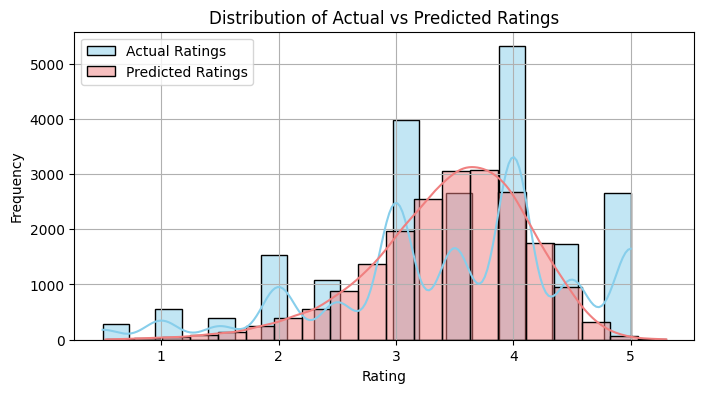

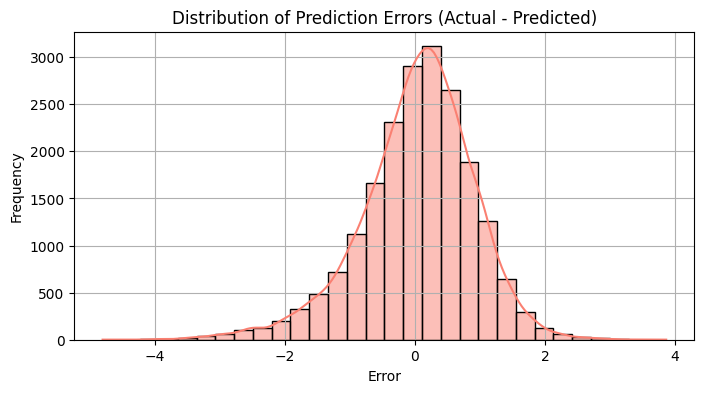

In [249]:
# Memvisualisasikan distribusi rating aktual vs prediksi
plt.figure(figsize=(8, 4))
sns.histplot(y_val, bins=20, kde=True, color='skyblue', label='Actual Ratings')
sns.histplot(preds.flatten(), bins=20, kde=True, color='lightcoral', label='Predicted Ratings')
plt.title('Distribution of Actual vs Predicted Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Memvisualisasikan error (selisih) antara rating aktual dan prediksi
errors = y_val - preds.flatten()
plt.figure(figsize=(8, 4))
sns.histplot(errors, bins=30, kde=True, color='salmon')
plt.title('Distribution of Prediction Errors (Actual - Predicted)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

1. Visualisasi Distribusi Rating Aktual vs Prediksi (Plot Atas)
  - Warna biru: Distribusi rating aktual dari pengguna.
  - Warna merah muda: Distribusi rating yang diprediksi oleh model.
  - Kedua distribusi relatif mirip, menunjukkan bahwa model berhasil meniru pola rating aktual dengan cukup baik.
  - Perbedaan mencolok terlihat pada rating integer tertentu seperti 3.0, 4.0, dan 5.0, yang sering dipakai oleh pengguna asli, sedangkan model membuat prediksi dalam angka desimal kontinu.


2. Visualisasi Distribusi Error Prediksi (Plot Bawah)
  - Ini menunjukkan distribusi dari selisih rating aktual dan prediksi (Actual - Predicted).
  - Bentuk kurva menyerupai distribusi normal (Gaussian) dengan puncak di sekitar 0, yang berarti:
  - Mayoritas prediksi cukup akurat (selisih kecil antara nilai aktual dan prediksi).
  - Tidak banyak error ekstrem (outlier sedikit).

### Evaluasi pada Content-Based Filtering

Evaluasi pada content-based filtering, menggunakan metrik evaluasi:
- Precision@K untuk mengukur proporsi item yang relevan di antara top-K rekomendasi
- Recall@K untuk mengukur seberapa banyak item relevan yang berhasil ditemukan dari semua item relevan yang ada.
- F1-Score@K merupakan kombinasi dari precision dan recall.

In [250]:
# --- Fungsi-fungsi Evaluasi ---
def precision_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    hit_count = sum(1 for item in recommended_k if item in relevant_set)
    return hit_count / k

def recall_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    hit_count = sum(1 for item in recommended_k if item in relevant_set)
    return hit_count / len(relevant_set) if relevant_set else 0

def f1_score_at_k(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

In [251]:
# Fungsi rekomendasi dan evaluasi
def recommend_and_evaluate(title, top_n, relevance_threshold):
    idx = indices[title]

    # informasi film
    base_movie_info = movies.iloc[idx][['title', 'genres', 'combined_genre_tag']]
    print(f"--- Informasi Film: ---\n")
    print(base_movie_info.to_string())
    print("\n------------------------------")

    sim_scores = list(enumerate(cosine_sim[idx]))

    # Mendapatkan hasil rekomendasi (top_n)
    recommended_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    recommended_indices = [i[0] for i in recommended_scores]
    recommended_df = movies.iloc[recommended_indices][['title', 'genres', 'tag', 'combined_genre_tag']]
    recommended_titles = recommended_df['title'].tolist()

    # Mendapatkan film yang dianggap relevan (skor sim > threshold)
    # Memastikan index 0 (film itu sendiri) tidak termasuk
    relevant_indices_potential = [i[0] for i in sim_scores if i[1] >= relevance_threshold and i[0] != idx]
    relevant_titles = movies.iloc[relevant_indices_potential]['title'].tolist()

    # Menghitung metrik evaluasi
    precision = precision_at_k(recommended_titles, relevant_titles, top_n)
    recall = recall_at_k(recommended_titles, relevant_titles, top_n)
    f1 = f1_score_at_k(precision, recall)

    # Menampilkan hasil
    print(f"\n🎬 Rekomendasi untuk \"{title}\":\n")
    print(recommended_df[['title', 'genres', 'combined_genre_tag']].to_string(index=False))

    print(f"\n📊 Evaluasi Content-Based Filtering @Top-{top_n} (Relevance Threshold={relevance_threshold})")
    print(f"Precision@{top_n}: {precision:.4f}")
    print(f"Recall@{top_n}:    {recall:.4f}")
    print(f"F1-Score@{top_n}:  {f1:.4f}")

# Menjalankan fungsi rekomendasi dan evaluasi
recommend_and_evaluate("God Loves Caviar (2012)", top_n=15, relevance_threshold=0.8)

--- Informasi Film: ---

title                 God Loves Caviar (2012)
genres                            [adventure]
combined_genre_tag                  adventure

------------------------------

🎬 Rekomendasi untuk "God Loves Caviar (2012)":

                                     title             genres combined_genre_tag
      Beyond the Poseidon Adventure (1979)        [adventure]          adventure
                 White Water Summer (1987)        [adventure]          adventure
                          Iron Will (1994)        [adventure]          adventure
              Mountains of the Moon (1990)        [adventure]          adventure
                         White Fang (1991)        [adventure]          adventure
             Wind and the Lion, The (1975)        [adventure]          adventure
Christopher Columbus: The Discovery (1992)        [adventure]          adventure
                    Treasure Island (2012)        [adventure]          adventure
                   God Love

### Perbandingan kedua algoritma

1. Neural Collaborative Filtering (NCF)
  - Root Mean Square Error (RMSE): 0.8754
  - Ini menunjukkan kualitas prediksi rating oleh model NCF.
  - RMSE di bawah 1.0 menandakan model cukup baik dalam memprediksi preferensi pengguna.

2. Content-Based Filtering
  - Menggunakan kemiripan fitur (genre + tag) antar film.
  - Model Content-Based Filtering memiliki nilai
      - Precision@15: 0.9333
      - Recall@15:    0.1892
      - F1-Score@15:  0.3146
  
    Nilai-nilai ini menunjukkan seberapa efektif model ini dalam merekomendasikan item yang relevan dalam daftar top-K berdasarkan kemiripan konten.

- Kesimpulan
  - Model NCF telah berhasil dilatih dengan baik, memiliki error prediksi rendah.
  - Content-Based Filtering memberikan rekomendasi yang konsisten secara semantik berdasarkan kemiripan konten.
  - Kombinasi keduanya dapat memberikan sistem rekomendasi yang kuat dan fleksibel (Hybrid Recommender System).